In [1]:
!pip install tensorflow_addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.callbacks import TensorBoard
#import tensorflow_addons as tfa

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 1.1 MB 786 kB/s eta 0:00:01


Using TensorFlow backend.


In [42]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32
num_epochs = 150
image_size = 128  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

num_classes = 2
input_shape = (128, 128, 1)
 
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



In [3]:
data = np.load('alldatas.npy')
idhlabel = np.load('idhlabels.npy')
ki67label = np.load('ki67labels.npy')
MGMTlabel = np.load('MGMTlabels.npy')
p53label = np.load('p53labels.npy')
#x_test = np.load('testdata.npy')
#y_testidh = np.load('testidhlabel.npy')
#y_testki67 = np.load('testki67label.npy')
split = train_test_split(data, idhlabel, ki67label, MGMTlabel, p53label, test_size=0.20, random_state=42)
(x_train, x_test, y_trainidh, y_testidh, y_trainki67, y_testki67, y_trainMGMT, y_testMGMT, y_trainp53, y_testp53) = split
#x_train = a
#y_train = c
#x_test = b
#y_test = d
print(f"x_train shape: {x_train.shape} - y_trainidh shape: {y_trainidh.shape} - y_trainki67 shape: {y_trainki67.shape} - y_trainMGMT shape: {y_trainMGMT.shape} - y_trainp53 shape: {y_trainp53.shape}")
print(f"x_test shape: {x_test.shape} - y_testidh shape: {y_testidh.shape} - y_testki67 shape: {y_testki67.shape} - y_testMGMT shape: {y_testMGMT.shape} - y_testp53 shape: {y_testp53.shape}")


x_train shape: (1692, 128, 128) - y_trainidh shape: (1692,) - y_trainki67 shape: (1692,) - y_trainMGMT shape: (1692,) - y_trainp53 shape: (1692,)
x_test shape: (423, 128, 128) - y_testidh shape: (423,) - y_testki67 shape: (423,) - y_testMGMT shape: (423,) - y_testp53 shape: (423,)


In [43]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
 
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#import matplotlib.pyplot as plt
 
#plt.figure(figsize=(4, 4))
#image = x_train[np.random.choice(range(x_train.shape[0]))]
#plt.imshow(image.astype("uint8"))
#plt.axis("off")
 
#resized_image = tf.image.resize(
#    tf.convert_to_tensor([image]), size=(image_size, image_size)
#)
#patches = Patches(patch_size)(resized_image)
#print(f"Image size: {image_size} X {image_size}")
#print(f"Patch size: {patch_size} X {patch_size}")
#print(f"Patches per image: {patches.shape[1]}")
#print(f"Elements per patch: {patches.shape[-1]}")
 
#n = int(np.sqrt(patches.shape[1]))
#plt.figure(figsize=(4, 4))
#for i, patch in enumerate(patches[0]):
#    ax = plt.subplot(n, n, i + 1)
#    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#    plt.imshow(patch_img.numpy().astype("uint8"))
#    plt.axis("off")

(128, 128)
Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 64


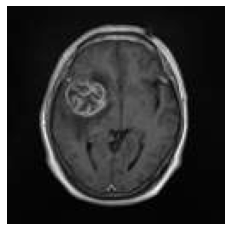

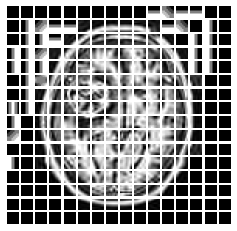

In [52]:
import matplotlib.pyplot as plt
import cv2
I = cv2.imread('cc_1.jpg')
b, g, r = cv2.split(I)
b = np.array(b)
print(b.shape)
plt.figure(figsize=(4, 4))
#image = I_array[np.random.choice(range(I_array.shape[3]))]
image =b
plt.imshow(image.astype("uint8"),cmap='gray')
plt.axis("off")
plt.savefig("org.png")
 
#resized_image = tf.image.resize(
#    tf.convert_to_tensor([image]), size=(image_size, image_size)
#)
image = image[np.newaxis,:,:,np.newaxis]
patches = Patches(patch_size)(image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
 
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap='gray')
    plt.axis("off")
    



In [5]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [6]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape, name='img')
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
 
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
 
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    idhout = layers.Dense(num_classes,name='idh_out1')(features)
    ki67out = layers.Dense(num_classes,name='ki67_out2')(features)
    MGMTout = layers.Dense(num_classes,name='MGMT_out3')(features)
    p53out = layers.Dense(num_classes,name='p53_out4')(features)
    #logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    #model = keras.Model(inputs=inputs, outputs=logits)
    model = keras.Model(inputs=[inputs], outputs=[idhout, ki67out, MGMTout, p53out])
    return model



In [7]:
def run_experiment(model):
    #optimizer = tfa.optimizers.AdamW(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate
        #, weight_decay=weight_decay
    )
 
    model.compile(
        optimizer=optimizer,
        #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss= {'idh_out1': keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               'ki67_out2': keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               'MGMT_out3': keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               'p53_out4': keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              },        
        #loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        loss_weights={'idh_out1': 1., 'ki67_out2': 1., 'MGMT_out3': 1., 'p53_out4': 1.},
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
            #keras.metrics.CategoricalAccuracy(name="accuracy"),
            #keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
 
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        #monitor="val_accuracy",
        monitor="val_idh_out1_accuracy",
        save_best_only=True,
        save_weights_only=True,
        mode='max'
    )
    
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)
 
    #history = model.fit(
        #x=x_train,
        #y=y_train,
        #batch_size=batch_size,
        #epochs=num_epochs,
        #validation_split=0.1,
        #callbacks=[checkpoint_callback],
    #)
    history = model.fit(
        x_train,
        {'idh_out1': y_trainidh, 'ki67_out2': y_trainki67, 'MGMT_out3': y_trainMGMT, 'p53_out4': y_trainp53},
        batch_size=batch_size,
        epochs=num_epochs,
        #validation_data=(x_test, {'idh_out1': y_testidh, 'ki67_out2': y_testki67}),
        validation_split=0.1,
        callbacks=[checkpoint_callback,tensorboard]
    )
 
    #model.load_weights(checkpoint_filepath)
    #_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    _, loss1, loss2, loss3, loss4, accuracy1, accuracy2, accuracy3, accuracy4 = model.evaluate(x_test,{'idh_out1': y_testidh, 'ki67_out2': y_testki67, 'MGMT_out3': y_testMGMT, 'p53_out4': y_testp53})
    print(f"loss: {round(_ * 100, 2)}%")
    print(f"idhTest loss: {round(loss1 * 100, 2)}%")
    print(f"idhTest accuracy: {round(accuracy1 * 100, 2)}%")
    print(f"ki67Test loss: {round(loss2 * 100, 2)}%")
    print(f"ki67Test accuracy: {round(accuracy2 * 100, 2)}%")
    print(f"MGMTTest loss: {round(loss3 * 100, 2)}%")
    print(f"MGMTTest accuracy: {round(accuracy3 * 100, 2)}%")
    print(f"p53Test loss: {round(loss4 * 100, 2)}%")
    print(f"p53Test accuracy: {round(accuracy4 * 100, 2)}%")
    
    
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
 
    return history
 
 
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/150
48/48 [==============================] - 29s 395ms/step - loss: 5.6073 - idh_out1_loss: 1.5386 - ki67_out2_loss: 1.1544 - MGMT_out3_loss: 1.5476 - p53_out4_loss: 1.3667 - idh_out1_accuracy: 0.5073 - ki67_out2_accuracy: 0.6675 - MGMT_out3_accuracy: 0.5190 - p53_out4_accuracy: 0.5518 - val_loss: 2.6147 - val_idh_out1_loss: 0.8249 - val_ki67_out2_loss: 0.5053 - val_MGMT_out3_loss: 0.6744 - val_p53_out4_loss: 0.6101 - val_idh_out1_accuracy: 0.6765 - val_ki67_out2_accuracy: 0.8412 - val_MGMT_out3_accuracy: 0.5824 - val_p53_out4_accuracy: 0.7000
Epoch 2/150
48/48 [==============================] - 15s 322ms/step - loss: 3.9473 - idh_out1_loss: 1.1370 - ki67_out2_loss: 0.7761 - MGMT_out3_loss: 1.0654 - p53_out4_loss: 0.9686 - idh_out1_accuracy: 0.5440 - ki67_out2_accuracy: 0.7223 - MGMT_out3_accuracy: 0.5369 - p53_out4_accuracy: 0.5947 - val_loss: 2.6985 - val_idh_out1_loss: 0.9224 - val_ki67_out2_loss: 0.4372 - val_MGMT_out3_loss: 0.7309 - val_p53_out4_loss: 0.6080 - val_idh_out1